# Forward Modeling of an Emission Spectrum using the DIT Cross Section

In [1]:
from exojax.spec import rtransfer as rt
from exojax.spec import dit
from exojax.spec import lpf

In [2]:
#ATMOSPHERE                                                                     
NP=100
T0=1295.0 #K
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = T0*(Parr)**0.1

A T-P profile we assume is ...  

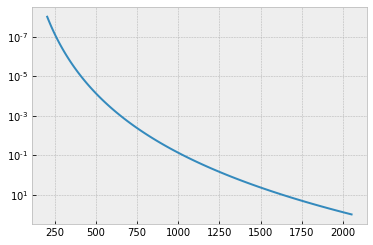

In [3]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.plot(Tarr,Parr)
plt.yscale("log")
plt.gca().invert_yaxis()
plt.show()

We set a wavenumber grid using nugrid.

In [4]:
from exojax.spec.rtransfer import nugrid
nus,wav,res=nugrid(16360,16560,10000,unit="AA",xsmode="dit")

nugrid is linear: mode= dit


Loading a molecular database of CH4 and CIA (H2-H2)... 

In [5]:
from exojax.spec import moldb, contdb
mdbCH4=moldb.MdbExomol('.database/CH4/12C-1H4/YT10to10/',nus,crit=1.e-30)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Background atmosphere:  H2
Note: Couldn't find the hdf5 format. We convert data to the hdf5 format. After the second time, it will become much faster.
Reading transition file
.broad is used.
Broadening code level= a1
default broadening parameters are used for  12  J lower states in  29  states
H2-H2


In [6]:
len(mdbCH4.A)

140031

In [7]:
from exojax.spec import molinfo
molmassCH4=molinfo.molmass("CH4")

Computing the relative partition function, 

In [8]:
from jax import vmap
qt=vmap(mdbCH4.qr_interp)(Tarr)

Pressure and Natural broadenings 

In [9]:
from jax import jit
from exojax.spec.exomol import gamma_exomol
from exojax.spec import gamma_natural

gammaLMP = jit(vmap(gamma_exomol,(0,0,None,None)))\
        (Parr,Tarr,mdbCH4.n_Texp,mdbCH4.alpha_ref)
gammaLMN=gamma_natural(mdbCH4.A)
gammaLM=gammaLMP+gammaLMN[None,:]

Doppler broadening

In [10]:
from exojax.spec import doppler_sigma
sigmaDM=jit(vmap(doppler_sigma,(None,0,None)))\
        (mdbCH4.nu_lines,Tarr,molmassCH4)

And line strength

In [11]:
from exojax.spec import SijT
SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr,mdbCH4.logsij0,mdbCH4.nu_lines,mdbCH4.elower,qt)

DIT

In [12]:
dgm_sigmaD=dit.dgmatrix(sigmaDM,0.1)
dgm_gammaL=dit.dgmatrix(gammaLM,0.2)

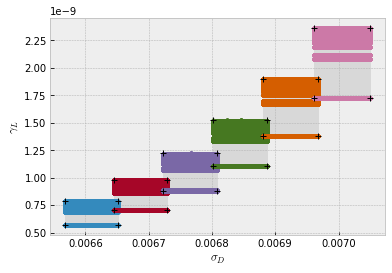

In [13]:
#show the DIT grids 
from exojax.plot.ditplot import plot_dgm
plot_dgm(dgm_sigmaD,dgm_gammaL,sigmaDM,gammaLM,0,6)

In [14]:
from exojax.spec import initspec 
cnu,indexnu,pmarray=initspec.init_dit(mdbCH4.nu_lines,nus)
xsmdit=dit.xsmatrix(cnu,indexnu,pmarray,sigmaDM,gammaLM,SijM,nus,dgm_sigmaD,dgm_gammaL)

/tmp/ipykernel_31797/3074525130.py:4: RuntimeWarning: divide by zero encountered in log10
  c=plt.imshow(np.log10(xsmdit),cmap="bone_r",vmin=-23,vmax=-19)
/tmp/ipykernel_31797/3074525130.py:4: RuntimeWarning: invalid value encountered in log10
  c=plt.imshow(np.log10(xsmdit),cmap="bone_r",vmin=-23,vmax=-19)


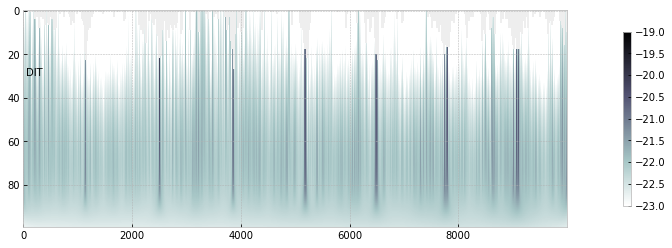

In [15]:
import numpy as np
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(111)
c=plt.imshow(np.log10(xsmdit),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"DIT")
ax.set_aspect(0.4/ax.get_data_ratio())
plt.show()

computing delta tau for CH4

In [16]:
from exojax.spec.rtransfer import dtauM
import jax.numpy as jnp
Rp=0.88
Mp=33.2
g=2478.57730044555*Mp/Rp**2
#g=1.e5 #gravity cm/s2
MMR=0.0059 #mass mixing ratio

# 0-padding for negative values
xsmnp=np.array(xsmdit)
print(len(xsmnp[xsmnp<0.0]))
xsmnp[xsmnp<0.0]=0.0
xsmditc=jnp.array(xsmnp)
#-------------------------------

dtaum=dtauM(dParr,xsmditc,MMR*np.ones_like(Tarr),molmassCH4,g)

4222


computing delta tau for CIA

In [17]:
from exojax.spec.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

The total delta tau is a summation of them

In [18]:
dtau=dtaum+dtaucH2H2

you can plot a contribution function using exojax.plot.atmplot 

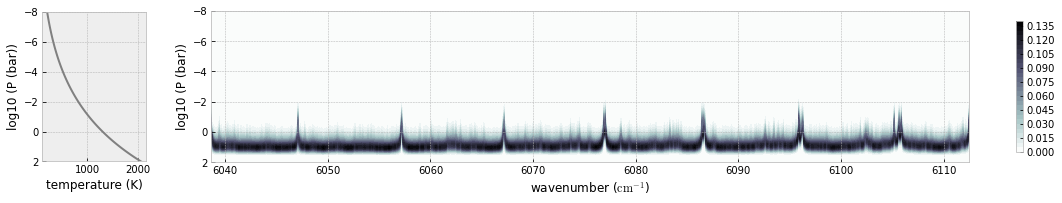

In [19]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau,Tarr,Parr,dParr)
plt.show()

radiative transfering...

In [20]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr,nus)
F0=rtrun(dtau,sourcef)

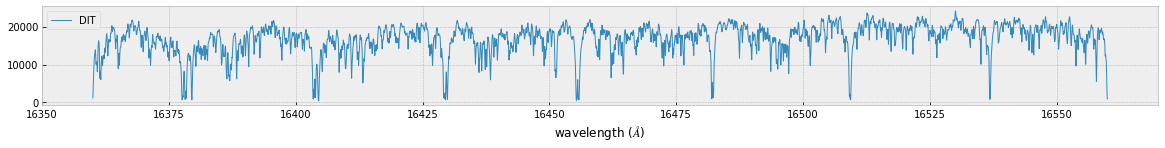

In [21]:
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(211)
plt.plot(wav[::-1],F0,lw=1,label="DIT")
plt.legend()
plt.xlabel("wavelength ($\AA$)")
plt.savefig("ch4.png")